### Importing first set of libraries to extract data from Wikipedia

In [1]:
import pandas as pd
import numpy as np
import urllib.request
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors#
from matplotlib import pyplot as plt

In [2]:
pd.options.display.max_rows = 100

### Loading data from Wikipedia and exporting it into a dataframe

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")
right_table = soup.find("table", class_ = "wikitable sortable")

postal_code = []
borough = []
neighborhood = []

for row in right_table.findAll("tr"):
    cells = row.findAll("td")
    if len(cells) == 3:
        postal_code.append(cells[0].find(text = True).replace("\n", ""))
        borough.append(cells[1].find(text = True).replace("\n", ""))
        neighborhood.append(cells[2].find(text = True).replace("\n", ""))

df = pd.DataFrame(postal_code, columns = ["Postal Code"])
df["Borough"] = borough
df["Neighborhood"] = neighborhood
print(df.shape)
df.head()

(180, 3)


,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Dropping rows where Borough is "Not assigned"

In [4]:
df.replace("Not assigned", np.nan, inplace = True)
df.dropna(subset = ["Borough"], inplace = True)
df.reset_index(drop = True, inplace = True)
print(df.shape)
df.head()

(103, 3)


,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Importing libraties to get geodata and query geodata for postal codes

In [5]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut

In [6]:
geolocator = Nominatim(user_agent = "coursera_project")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 1.5)

latitude_list = []
longitude_list = []

for postal_code in range(len(df)):
    location = geolocator.geocode(df.iloc[postal_code, 0], timeout = 10)
    if location == None:
        latitude = np.nan
        longitude = np.nan
    else:
        latitude = location.latitude
        longitude = location.longitude
    latitude_list.append(latitude)
    longitude_list.append(longitude)

latitude = pd.Series(latitude_list)
longitude = pd.Series(longitude_list)

print("Getting Latitude data failed for " + latitude.isna().sum().astype(str) + " postal codes")

Getting Latitude data failed for 56 postal codes


### IF the request was sucessfull the data from Nominatim will be used. As this is often unsuccesfull there is logic here to use the data from https://cocl.us/Geospatial_data instead if Nominatim failed

In [7]:
if latitude.isna().sum() > 0:
    url = "https://cocl.us/Geospatial_data"
    df = pd.merge(df, pd.read_csv(url), on = "Postal Code", how = "left")
else:
    df["Latitude"] = latitude.values
    df["Longitude"] = longitude.values
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [8]:
print("The dataframe has {} boroughs and {} neighborhoods.".format(len(df["Borough"].unique()),df.shape[0]))

The dataframe has 10 boroughs and 103 neighborhoods.


### Count the number of Neighborhoods in each Borough

In [9]:
df[["Borough", "Neighborhood"]].groupby(by = ["Borough"]).count()

,Neighborhood
Borough,
Central Toronto,9
Downtown Toronto,19
East Toronto,5
East York,5
Etobicoke,12
Mississauga,1
North York,24
Scarborough,17
West Toronto,6


### Import folium to create map and define function to get coordinates

In [10]:
import folium

In [11]:
def get_coordinates(place):
    address_place = place
    location = geolocator.geocode(address_place, timeout = 10)
    latitude = location.latitude
    longitude = location.longitude
    return(latitude, longitude)

### Create a map of Toroto with neighboorhoods

In [12]:
map_toronto = folium.Map(location = [get_coordinates("Toronto, Canada")[0], get_coordinates("Toronto, Canada")[1]], zoom_start = 10)

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

   

In [13]:
 map_toronto

### Connect to Foursquare

In [14]:
import requests
from pandas.io.json import json_normalize

In [15]:
CLIENT_ID = '3WBEZJF1MOQYJPJIPHJ2R5CSORYSCFCWO2HWBE55DJJNYCLU' # your Foursquare ID
CLIENT_SECRET = 'RL51MYTZRN40LR5SX4F4WDTMTGVIEVZGDAFK0KNO5HWFF1QB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3WBEZJF1MOQYJPJIPHJ2R5CSORYSCFCWO2HWBE55DJJNYCLU
CLIENT_SECRET:RL51MYTZRN40LR5SX4F4WDTMTGVIEVZGDAFK0KNO5HWFF1QB


### Get nearby venues in Toronto

In [16]:
LIMIT = 100
radius = 500

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    

    return(nearby_venues)

In [18]:
toronto_venues = getNearbyVenues(names = df["Neighborhood"], latitudes = df["Latitude"], longitudes = df["Longitude"])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [19]:
print(toronto_venues.shape)
toronto_venues.head()

(2139, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [20]:
toronto_venues[["Neighborhood", "Venue"]].groupby("Neighborhood").count()

,Venue
Neighborhood,
Agincourt,5
"Alderwood, Long Branch",7
"Bathurst Manor, Wilson Heights, Downsview North",21
Bayview Village,4
"Bedford Park, Lawrence Manor East",22
Berczy Park,55
"Birch Cliff, Cliffside West",4
"Brockton, Parkdale Village, Exhibition Place",23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16


In [21]:
print("There are {} unique categories.".format(len(toronto_venues["Venue Category"].unique())))

There are 274 unique categories.


In [22]:
toronto_venues["Venue Category"] = toronto_venues["Venue Category"].str.replace("Neighborhood", "Neighborhoods")

### Prepare data and apply one hot encoding for machine learning algorithm

In [23]:
toronto_onehot = pd.get_dummies(toronto_venues[["Venue Category"]], prefix = "", prefix_sep = "")

toronto_onehot["Neighborhood"] = toronto_venues["Neighborhood"]

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(2139, 275)


,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
toronto_grouped = toronto_onehot.groupby("Neighborhood").mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped

(96, 275)


,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
1,"Alderwood, Long Branch",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
3,Bayview Village,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.045455,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
5,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.00,0.0,0.018182,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
6,"Birch Cliff, Cliffside West",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
8,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.000000,...,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000


### print top 5 venues for each neighborhood

In [25]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0             Clothing Store   0.2
1             Breakfast Spot   0.2
2                     Lounge   0.2
3               Skating Rink   0.2
4  Latin American Restaurant   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.29
1             Gym  0.14
2  Sandwich Place  0.14
3     Coffee Shop  0.14
4             Pub  0.14


----Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0         Bank  0.10
1  Coffee Shop  0.10
2     Pharmacy  0.05
3        Diner  0.05
4  Gas Station  0.05


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1   Chinese Restaurant  0.25
2                 Bank  0.25
3                 Café  0.25
4    Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.09
1         Coffee Shop  0.09
2  Italian Restaurant  0.09
3            Pharmacy  0.05
4                 Pub  0.05

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Show 10 most common venues for each neighborhood in Toronto

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Clothing Store,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Coffee Shop,Pub,Pharmacy,Gym,Grocery Store,Deli / Bodega,Electronics Store,Eastern European Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Frozen Yogurt Shop,Chinese Restaurant,Shopping Mall,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant,Supermarket
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Grocery Store,Thai Restaurant,Locksmith,Liquor Store,Comfort Food Restaurant,Butcher,Juice Bar
5,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Bakery,Beer Bar,Cheese Shop,Seafood Restaurant,Restaurant,Beach,Fish Market
6,"Birch Cliff, Cliffside West",College Stadium,Café,General Entertainment,Skating Rink,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
7,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Restaurant,Stadium,Bar,Bakery,Intersection,Furniture / Home Store
8,"Business reply mail Processing Centre, South C...",Park,Garden Center,Skate Park,Farmers Market,Fast Food Restaurant,Light Rail Station,Burrito Place,Butcher,Restaurant,Recording Studio
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Harbor / Marina,Bar,Plane,Coffee Shop,Rental Car Location,Sculpture Garden,Boat or Ferry,Boutique


### Import library for k-means clustering

In [28]:
from sklearn.cluster import KMeans

In [29]:
from sklearn.metrics import silhouette_score

In [31]:
toronto_grouped_clustering = toronto_grouped.drop("Neighborhood", 1)

### Identify best value for K-means clustering

In [35]:
sil = []
kmax = 20

for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(toronto_grouped_clustering, labels, metric = "euclidean"))

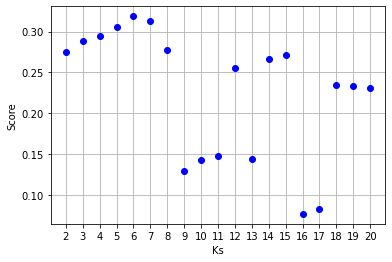

Best value for k with a score of 0.31868944378377645 is 6.


In [36]:
line = np.array(sil)
plt.xlabel("Ks")
plt.ylabel("Score")
plt.plot(line, "ro", color = "b", linewidth = 1.0)
plt.grid()
plt.xticks(np.arange(len(line)), np.arange(2, len(line) + 2))
plt.show()
print("Best value for k with a score of {} is {}.".format(max(sil),sil.index(max(sil)) + 2))

In [37]:
k_opt = sil.index(max(sil)) + 2

In [38]:
kclusters = k_opt

kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [39]:
neighborhoods_venues_sorted.insert(0, "Cluster Labels", kmeans.labels_)

In [40]:
toronto_merged = df.join(neighborhoods_venues_sorted.set_index("Neighborhood"), on = "Neighborhood")
toronto_merged

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Pizza Place,Hockey Arena,Coffee Shop,Portuguese Restaurant,Intersection,Convenience Store,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Distribution Center,Chocolate Shop,Mexican Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Accessories Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Coffee Shop,Yoga Studio,College Auditorium,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Café,Restaurant,Chinese Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,1.0,River,Pool,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1.0,Coffee Shop,Gay Bar,Japanese Restaurant,Sushi Restaurant,Restaurant,Yoga Studio,Mediterranean Restaurant,Café,Pub,Hotel
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,1.0,Park,Garden Center,Skate Park,Farmers Market,Fast Food Restaurant,Light Rail Station,Burrito Place,Butcher,Restaurant,Recording Studio
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,5.0,Construction & Landscaping,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store


### Remove values with no data

In [41]:
toronto_merged.loc[toronto_merged["Cluster Labels"].isna(), :]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,M2M,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
toronto_merged = toronto_merged.loc[toronto_merged["Cluster Labels"].notna(), :]
toronto_merged.reset_index(drop = True, inplace = True)
toronto_merged["Cluster Labels"] = toronto_merged["Cluster Labels"].astype(int)

### Create map for K-Means

In [49]:
# create map
map_clusters = folium.Map(location=[get_coordinates("Toronto, Canada")[0], get_coordinates("Toronto, Canada")[1]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###